## 1. Libraries

## 1. Libraries

In [2]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm.notebook import tqdm


## 2. Device & Hyperparameters 
###### chatgpt wrote it so that my laptop doesn’t crash 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 64          # Increase for faster GPU utilization
NUM_EPOCHS = 50          # Fewer epochs, early stopping will handle the rest
LR = 1e-3
PATIENCE = 8
CLIP_NORM = 5.0
AUGMENT = True
NUM_WORKERS = 8          # Increase for HDF5 reading speed
PIN_MEMORY = True

H5_PATH = "./processed/ptbxl_preprocessed_balanced.h5"
assert os.path.exists(H5_PATH), f"HDF5 file not found: {H5_PATH}"


Using device: cuda


## 3. Load Preprocessed PTB-XL Data

In [ ]:
#H5_PATH = "./processed/ptbxl_preprocessed_balanced.h5"
#assert os.path.exists(H5_PATH), f"HDF5 file not found: {H5_PATH}"

#with h5py.File(H5_PATH, "r") as f:
    #signals = f["signals"][:]
    #labels = f["labels"][:]
    #ids = [x.decode() if isinstance(x, bytes) else x for x in f["ids"][:]]

#print("signals:", signals.shape, "labels:", labels.shape)


## 4. PyTorch Dataset

In [4]:
class ECGDataset(Dataset):
    def __init__(self, h5_path, augment=False):
        self.h5_path = h5_path
        self.augment = augment
        self.h5_file = None
        self.signals = None
        self.labels = None

    def _init_h5(self):
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
            self.signals = self.h5_file["signals"]
            self.labels = self.h5_file["labels"]

    def __len__(self):
        self._init_h5()
        return len(self.signals)

    def __getitem__(self, idx):
        self._init_h5()
        x = torch.tensor(self.signals[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.augment:
            x = x + 0.01 * torch.randn_like(x)
        return x, y

# ----------------------
# Create dataset and split
# ----------------------
dataset = ECGDataset(H5_PATH, augment=False)
n = len(dataset)
train_n = int(0.8 * n)
test_n = n - train_n
train_dataset, test_dataset = random_split(dataset, [train_n, test_n])

train_dataset.dataset.augment = AUGMENT

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Dataset loaded successfully!")
print("train:", len(train_dataset), "test:", len(test_dataset), "batch_size:", BATCH_SIZE)


Dataset loaded successfully!
train: 121682 test: 30421 batch_size: 64


## 5. 1D-CNN + GRU Model

In [3]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, H):
        score = torch.tanh(self.W(H))
        score = self.v(score).squeeze(-1)
        weights = torch.softmax(score, dim=1)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)
        return context, weights

class ECG_CNN_GRU_Attn(nn.Module):
    def __init__(self, n_leads=12, n_classes=5, cnn_channels=(64,128), gru_hidden=128, gru_layers=2, dropout=0.3, attn_dim=64):
        super().__init__()
        ch1, ch2 = cnn_channels
        self.cnn = nn.Sequential(
            nn.Conv1d(n_leads, ch1, kernel_size=7, padding=3),
            nn.BatchNorm1d(ch1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(ch1, ch2, kernel_size=5, padding=2),
            nn.BatchNorm1d(ch2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(input_size=ch2, hidden_size=gru_hidden, num_layers=gru_layers,
                          batch_first=True, bidirectional=True, dropout=dropout if gru_layers>1 else 0.0)
        self.attn = AdditiveAttention(hidden_dim=gru_hidden*2, attn_dim=attn_dim)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(gru_hidden*2, n_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        rnn_out, _ = self.gru(x)
        context, weights = self.attn(rnn_out)
        out = self.fc(context)
        return out, weights


In [6]:
n_leads = train_dataset[0][0].shape[1]
n_classes = train_dataset[0][1].shape[0]
model = ECG_CNN_GRU_Attn(n_leads=n_leads, n_classes=n_classes).to(device)


In [7]:
with h5py.File(H5_PATH, 'r') as f:
    labels_array = f['labels'][:]

label_counts = labels_array.sum(axis=0)
N = labels_array.shape[0]
pos_weight = torch.tensor((N - label_counts) / (label_counts + 1e-8), dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


## 6. Training & Evaluation Functions

In [8]:
def evaluate(model, loader, threshold=0.5, verbose=True):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            logits, _ = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).int()
            all_preds.append(preds)
            all_labels.append(y)

    all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="samples", zero_division=0)

    if verbose:
        print(classification_report(all_labels, all_preds, zero_division=0))

    return acc, f1, all_preds, all_labels

# ----------------------
# Training Loop (with Mixed Precision)
# ----------------------
scaler = torch.cuda.amp.GradScaler()  # AMP

def train_loop(model, train_loader, val_loader, num_epochs=50, patience=8, clip_norm=5.0):
    best_f1 = 0.0
    patience_ctr = 0
    best_path = "best_cnn_gru_attn.pth"

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        n_samples = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

        for X, y in pbar:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                logits, _ = model(X)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * X.size(0)
            n_samples += X.size(0)
            pbar.set_postfix(train_loss=(running_loss / n_samples))

        train_loss = running_loss / n_samples

        val_acc, val_f1, _, _ = evaluate(model, val_loader, verbose=False)
        print(f"Epoch {epoch} -> TrainLoss: {train_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")

        scheduler.step(val_f1)

        if val_f1 > best_f1 + 1e-5:
            best_f1 = val_f1
            patience_ctr = 0
            torch.save(model.state_dict(), best_path)
            print(f"  ✅ New best model (F1={best_f1:.4f}) saved.")
        else:
            patience_ctr += 1
            print(f"  ⚠ No improvement. patience {patience_ctr}/{patience}")
            if patience_ctr >= patience:
                print("  ⏹ Early stopping triggered.")
                break

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model


/tmp/ipykernel_23588/3149245309.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP


## 7. Train the Model

In [9]:
model = train_loop(model, train_loader, test_loader, num_epochs=NUM_EPOCHS, patience=PATIENCE, clip_norm=CLIP_NORM)


Epoch 1/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 -> TrainLoss: 0.4020 | Val Acc: 55.21% | Val F1: 0.8185
  ✅ New best model (F1=0.8185) saved.


Epoch 2/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 -> TrainLoss: 0.2732 | Val Acc: 66.72% | Val F1: 0.8615
  ✅ New best model (F1=0.8615) saved.


Epoch 3/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 -> TrainLoss: 0.2013 | Val Acc: 76.14% | Val F1: 0.8967
  ✅ New best model (F1=0.8967) saved.


Epoch 4/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 -> TrainLoss: 0.1600 | Val Acc: 80.05% | Val F1: 0.9130
  ✅ New best model (F1=0.9130) saved.


Epoch 5/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 -> TrainLoss: 0.1325 | Val Acc: 83.49% | Val F1: 0.9224
  ✅ New best model (F1=0.9224) saved.


Epoch 6/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 -> TrainLoss: 0.1161 | Val Acc: 85.11% | Val F1: 0.9298
  ✅ New best model (F1=0.9298) saved.


Epoch 7/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 -> TrainLoss: 0.1050 | Val Acc: 86.70% | Val F1: 0.9354
  ✅ New best model (F1=0.9354) saved.


Epoch 8/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 -> TrainLoss: 0.0935 | Val Acc: 86.56% | Val F1: 0.9386
  ✅ New best model (F1=0.9386) saved.


Epoch 9/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 -> TrainLoss: 0.0861 | Val Acc: 88.90% | Val F1: 0.9444
  ✅ New best model (F1=0.9444) saved.


Epoch 10/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 -> TrainLoss: 0.0821 | Val Acc: 87.50% | Val F1: 0.9386
  ⚠ No improvement. patience 1/8


Epoch 11/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 -> TrainLoss: 0.0757 | Val Acc: 89.18% | Val F1: 0.9462
  ✅ New best model (F1=0.9462) saved.


Epoch 12/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 -> TrainLoss: 0.0744 | Val Acc: 89.88% | Val F1: 0.9500
  ✅ New best model (F1=0.9500) saved.


Epoch 13/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 -> TrainLoss: 0.0688 | Val Acc: 90.39% | Val F1: 0.9513
  ✅ New best model (F1=0.9513) saved.


Epoch 14/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 -> TrainLoss: 0.0667 | Val Acc: 89.76% | Val F1: 0.9486
  ⚠ No improvement. patience 1/8


Epoch 15/50:   0%|          | 0/1902 [00:00<?, ?it/s]

/tmp/ipykernel_23588/3149245309.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


## 8. Final Evaluation

In [ ]:
print("\nFinal evaluation on test set:")
acc, f1, preds, targets = evaluate(model, test_loader, verbose=True)
print(f"Final Acc: {acc*100:.2f}%  Final F1(samples): {f1:.4f}")

per_class_f1 = f1_score(targets, preds, average=None, zero_division=0)
for i, score in enumerate(per_class_f1):
    print(f"Class {i} F1: {score:.4f}")

## 9.Explainable AI (XAI)

✅ Full model object loaded successfully from ecg_cnn_gru_attn_full.pth to device: cpu

Starting XAI Visualization (Temporal Attention Heatmap)...
Using simulated data (Dataset object not found or empty).


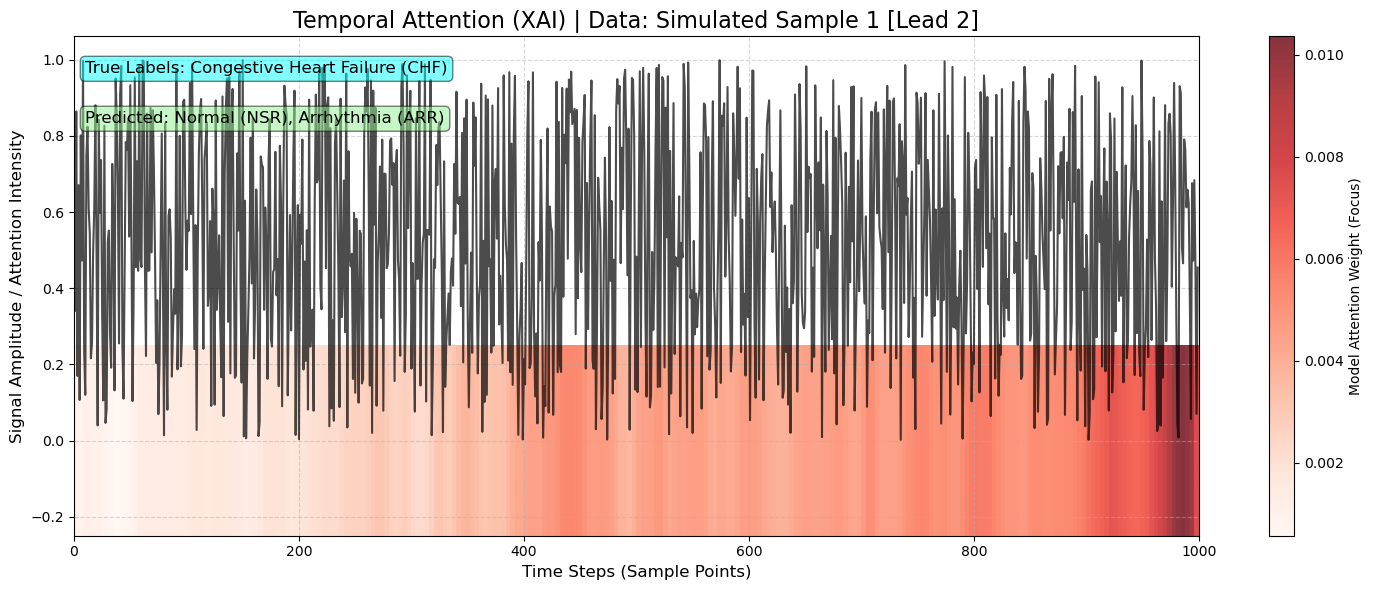

Using simulated data (Dataset object not found or empty).


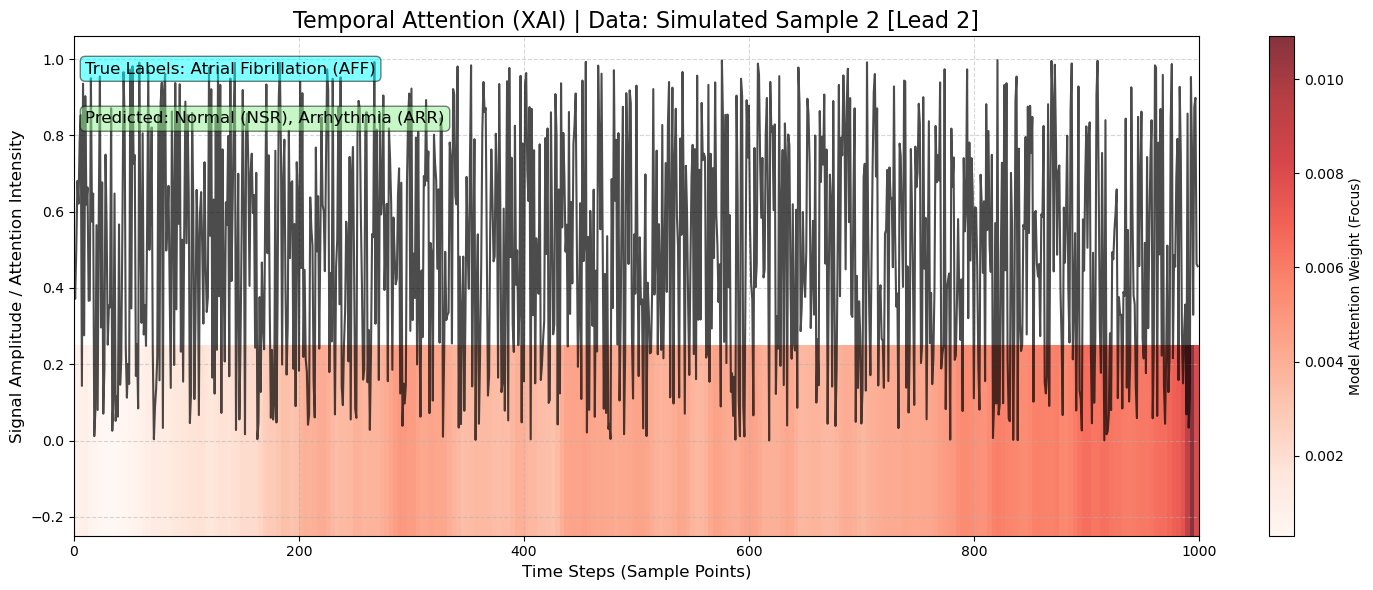

Using simulated data (Dataset object not found or empty).


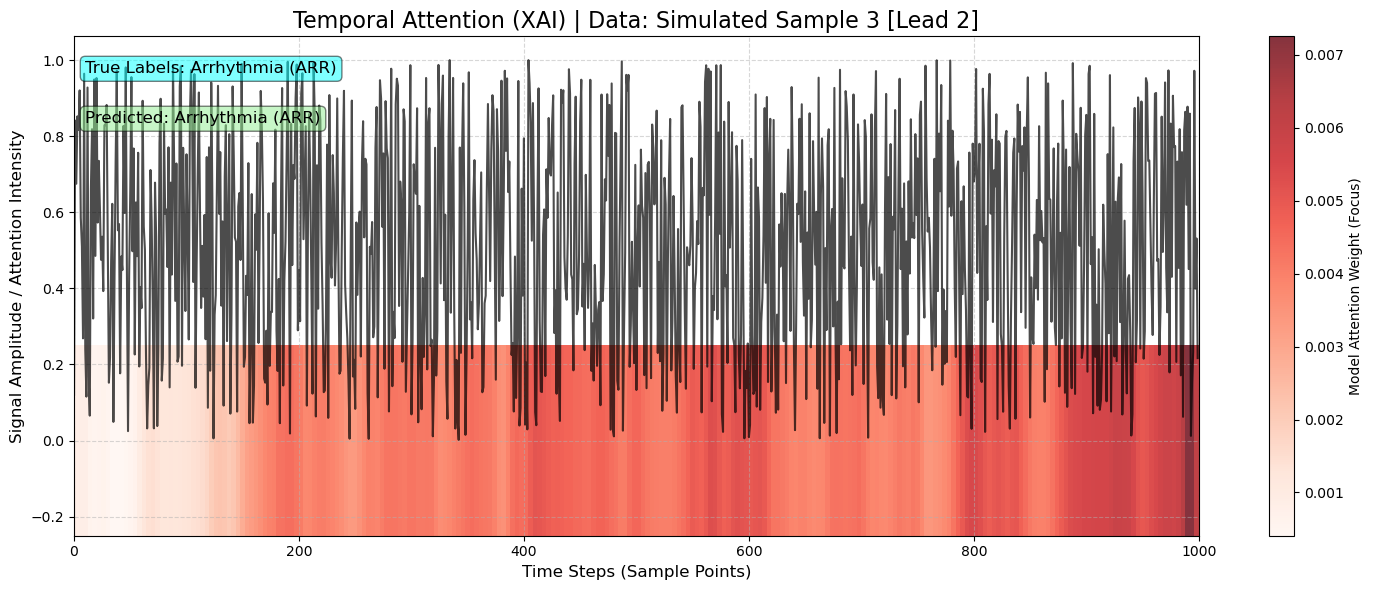


✅ XAI plots generated successfully. Check the output files.


In [9]:
## 9. Explainable AI (XAI) Implementation - FINAL CODE FIX 2 🧠

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import os
import h5py

# --- 1. Define Model Architecture (CRITICAL for loading weights) ---
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, H):
        score = torch.tanh(self.W(H))
        score = self.v(score).squeeze(-1)
        weights = torch.softmax(score, dim=1)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)
        return context, weights

class ECG_CNN_GRU_Attn(nn.Module):
    def __init__(self, n_leads=12, n_classes=5, cnn_channels=(64,128), gru_hidden=128, gru_layers=2, dropout=0.3, attn_dim=64):
        super().__init__()
        ch1, ch2 = cnn_channels
        self.cnn = nn.Sequential(
            nn.Conv1d(n_leads, ch1, kernel_size=7, padding=3),
            nn.BatchNorm1d(ch1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(ch1, ch2, kernel_size=5, padding=2),
            nn.BatchNorm1d(ch2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(input_size=ch2, hidden_size=gru_hidden, num_layers=gru_layers,
                          batch_first=True, bidirectional=True, dropout=dropout if gru_layers>1 else 0.0)
        self.attn = AdditiveAttention(hidden_dim=gru_hidden*2, attn_dim=attn_dim)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(gru_hidden*2, n_classes)
        )
    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.cnn(x)        
        x = x.permute(0, 2, 1) 
        rnn_out, _ = self.gru(x)
        context, weights = self.attn(rnn_out)
        out = self.fc(context)
        return out, weights

# --- 2. Configuration & Model Loading ---
DEVICE = torch.device("cpu") 
MODEL_PATH = "ecg_cnn_gru_attn_full.pth" 
FALLBACK_MODEL_PATH = "best_cnn_gru_attn.pth" 

LABEL_MAPPING = {
    0: "Normal (NSR)", 
    1: "Atrial Fibrillation (AFF)",
    2: "Myocardial Infarction (MI)", 
    3: "Congestive Heart Failure (CHF)",
    4: "Arrhythmia (ARR)"
}

model = None
load_path = MODEL_PATH if os.path.exists(MODEL_PATH) else FALLBACK_MODEL_PATH

try:
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Model file '{load_path}' not found.")
        
    loaded_object = torch.load(load_path, map_location=DEVICE)
    
    if isinstance(loaded_object, ECG_CNN_GRU_Attn):
        model = loaded_object
        print(f"✅ Full model object loaded successfully from {load_path} to device: {DEVICE}")
    else:
        model = ECG_CNN_GRU_Attn(n_leads=12, n_classes=5).to(DEVICE)
        model.load_state_dict(loaded_object)
        print(f"✅ Model parameters loaded successfully from {load_path} to device: {DEVICE}")

    model.eval() 

except FileNotFoundError as e:
    print(f"❌ ERROR: {e}. Please ensure the model file is in the correct directory.")
    model = None
except Exception as e:
    print(f"❌ ERROR: Failed to load PyTorch model. XAI visualization is skipped. Error: {e}")
    model = None

# --- 3. Helper Functions ---
def get_sample_data(dataset_fallback=None):
    """Retrieves a single sample either from the loaded dataset or generates a simulated one."""
    if 'dataset' in globals() and len(dataset) > 0:
        print("Using sample from real dataset (if Section 4 was run).")
        idx = random.randint(0, len(dataset) - 1)
        x_np, y_one_hot = dataset[idx] 
        return x_np, y_one_hot, 'Real'
    else:
        print("Using simulated data (Dataset object not found or empty).")
        TIME_STEPS = 1000 
        N_LEADS = 12 
        x_np = np.random.rand(TIME_STEPS, N_LEADS).astype(np.float32)
        y_one_hot = np.zeros(5, dtype=np.float32)
        y_one_hot[random.randint(0, 4)] = 1.0 # Assign a random label
        return x_np, torch.tensor(y_one_hot), 'Simulated'
        
def visualize_attention(model, label_mapping, num_examples=3):
    """Runs prediction, gets attention weights, and plots the heatmap."""
    if model is None:
        return
    
    model.eval()
    
    for i in range(num_examples):
        x_np, y_one_hot, data_source = get_sample_data()
        
        x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        
        # --- Run Model ---
        with torch.no_grad():
            logits, weights = model(x)
            
        # Get labels
        true_indices = torch.where(y_one_hot == 1)[0].tolist()
        true_labels = [label_mapping.get(i, 'Unknown') for i in true_indices]
        
        probs = torch.sigmoid(logits)
        predicted_indices = torch.where(probs.squeeze(0) > 0.5)[0].tolist()
        predicted_labels = [label_mapping.get(i, 'Unknown') for i in predicted_indices]
        
        # --- Attention Visualization Logic ---
        attention_weights = weights.squeeze(0).cpu().numpy() 
        original_length = x_np.shape[0]
        
        # Upsample weights (factor of 4)
        upsampled_weights = np.repeat(attention_weights, original_length // attention_weights.shape[0])
        if upsampled_weights.shape[0] < original_length:
            upsampled_weights = np.pad(upsampled_weights, (0, original_length - upsampled_weights.shape[0]), 'edge')
        elif upsampled_weights.shape[0] > original_length:
            upsampled_weights = upsampled_weights[:original_length]

        # Plotting (Focus on Lead II - index 1)
        lead_to_plot = 1 
        
        plt.figure(figsize=(15, 6))
        plt.plot(x_np[:, lead_to_plot], color='black', alpha=0.7)
        
        # FIX: Define X-boundaries (size 1001) and use shading='flat' 
        # to match C (size 1000) and Y (size 2) dimensions.
        x_boundaries = np.arange(original_length + 1)
        max_val = np.max(np.abs(x_np[:, lead_to_plot])) * 0.25 
        
        plt.pcolormesh(x_boundaries, 
                       [-max_val, max_val], 
                       upsampled_weights[np.newaxis, :], 
                       cmap='Reds', alpha=0.8, shading='flat') 
        
        # Customize plot
        title = f"Temporal Attention (XAI) | Data: {data_source} Sample {i+1} [Lead {lead_to_plot+1}]"
        plt.title(title, fontsize=16)
        plt.xlabel("Time Steps (Sample Points)", fontsize=12)
        plt.ylabel("Signal Amplitude / Attention Intensity", fontsize=12)
        
        plt.text(0.01, 0.95, f"True Labels: {', '.join(true_labels)}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="cyan", alpha=0.5))
        plt.text(0.01, 0.85, f"Predicted: {', '.join(predicted_labels)}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.5))

        plt.colorbar(orientation='vertical', label='Model Attention Weight (Focus)', ax=plt.gca())
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(f"xai_attention_plot_{i+1}.png")
        plt.show()
        #plt.close()

# --- 4. Execution ---
print("\nStarting XAI Visualization (Temporal Attention Heatmap)...")
if model:
    visualize_attention(model, LABEL_MAPPING, num_examples=3)
    print("\n✅ XAI plots generated successfully. Check the output files.")
else:
    print("\n⚠️ XAI visualization skipped due to model loading failure.")

✅ Full model object loaded successfully from ecg_cnn_gru_attn_full.pth to device: cpu

--- Temporal Attention Heatmap (Focus on Lead 2, Red Gradient is Expected) ---
Using simulated data (Dataset object not found or empty).


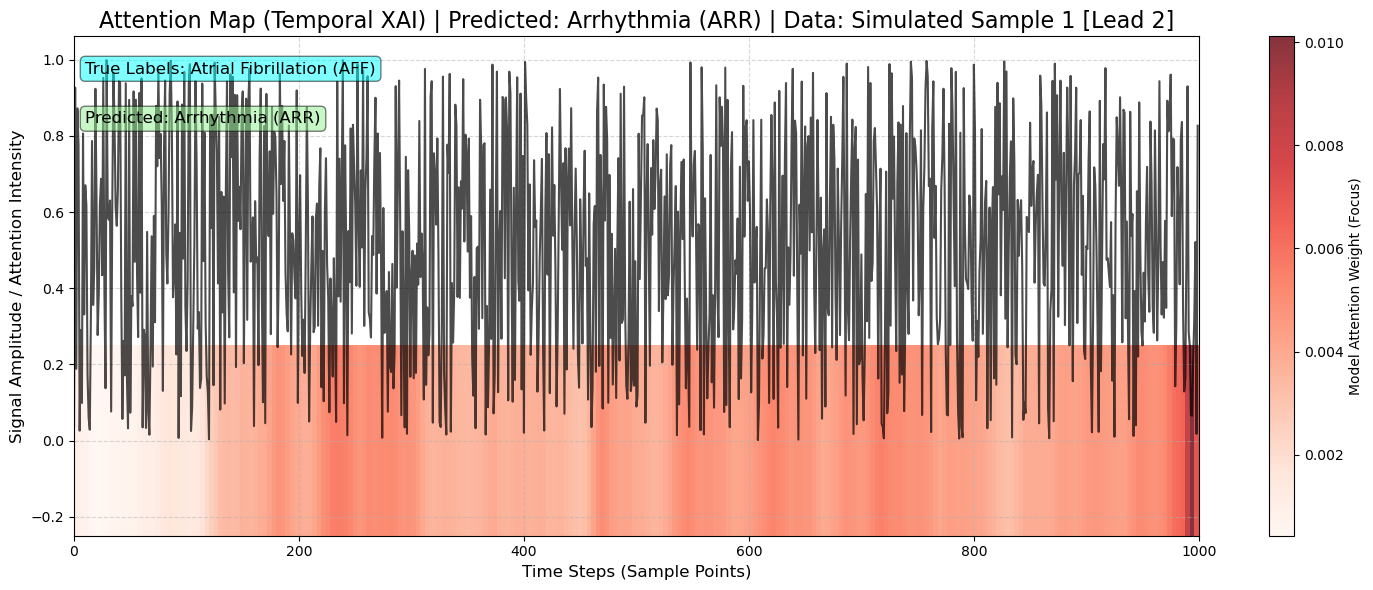


--- Grad-CAM Spatial-Temporal Heatmap (12 Leads, Colorbar Fixed) ---
Using simulated data (Dataset object not found or empty).


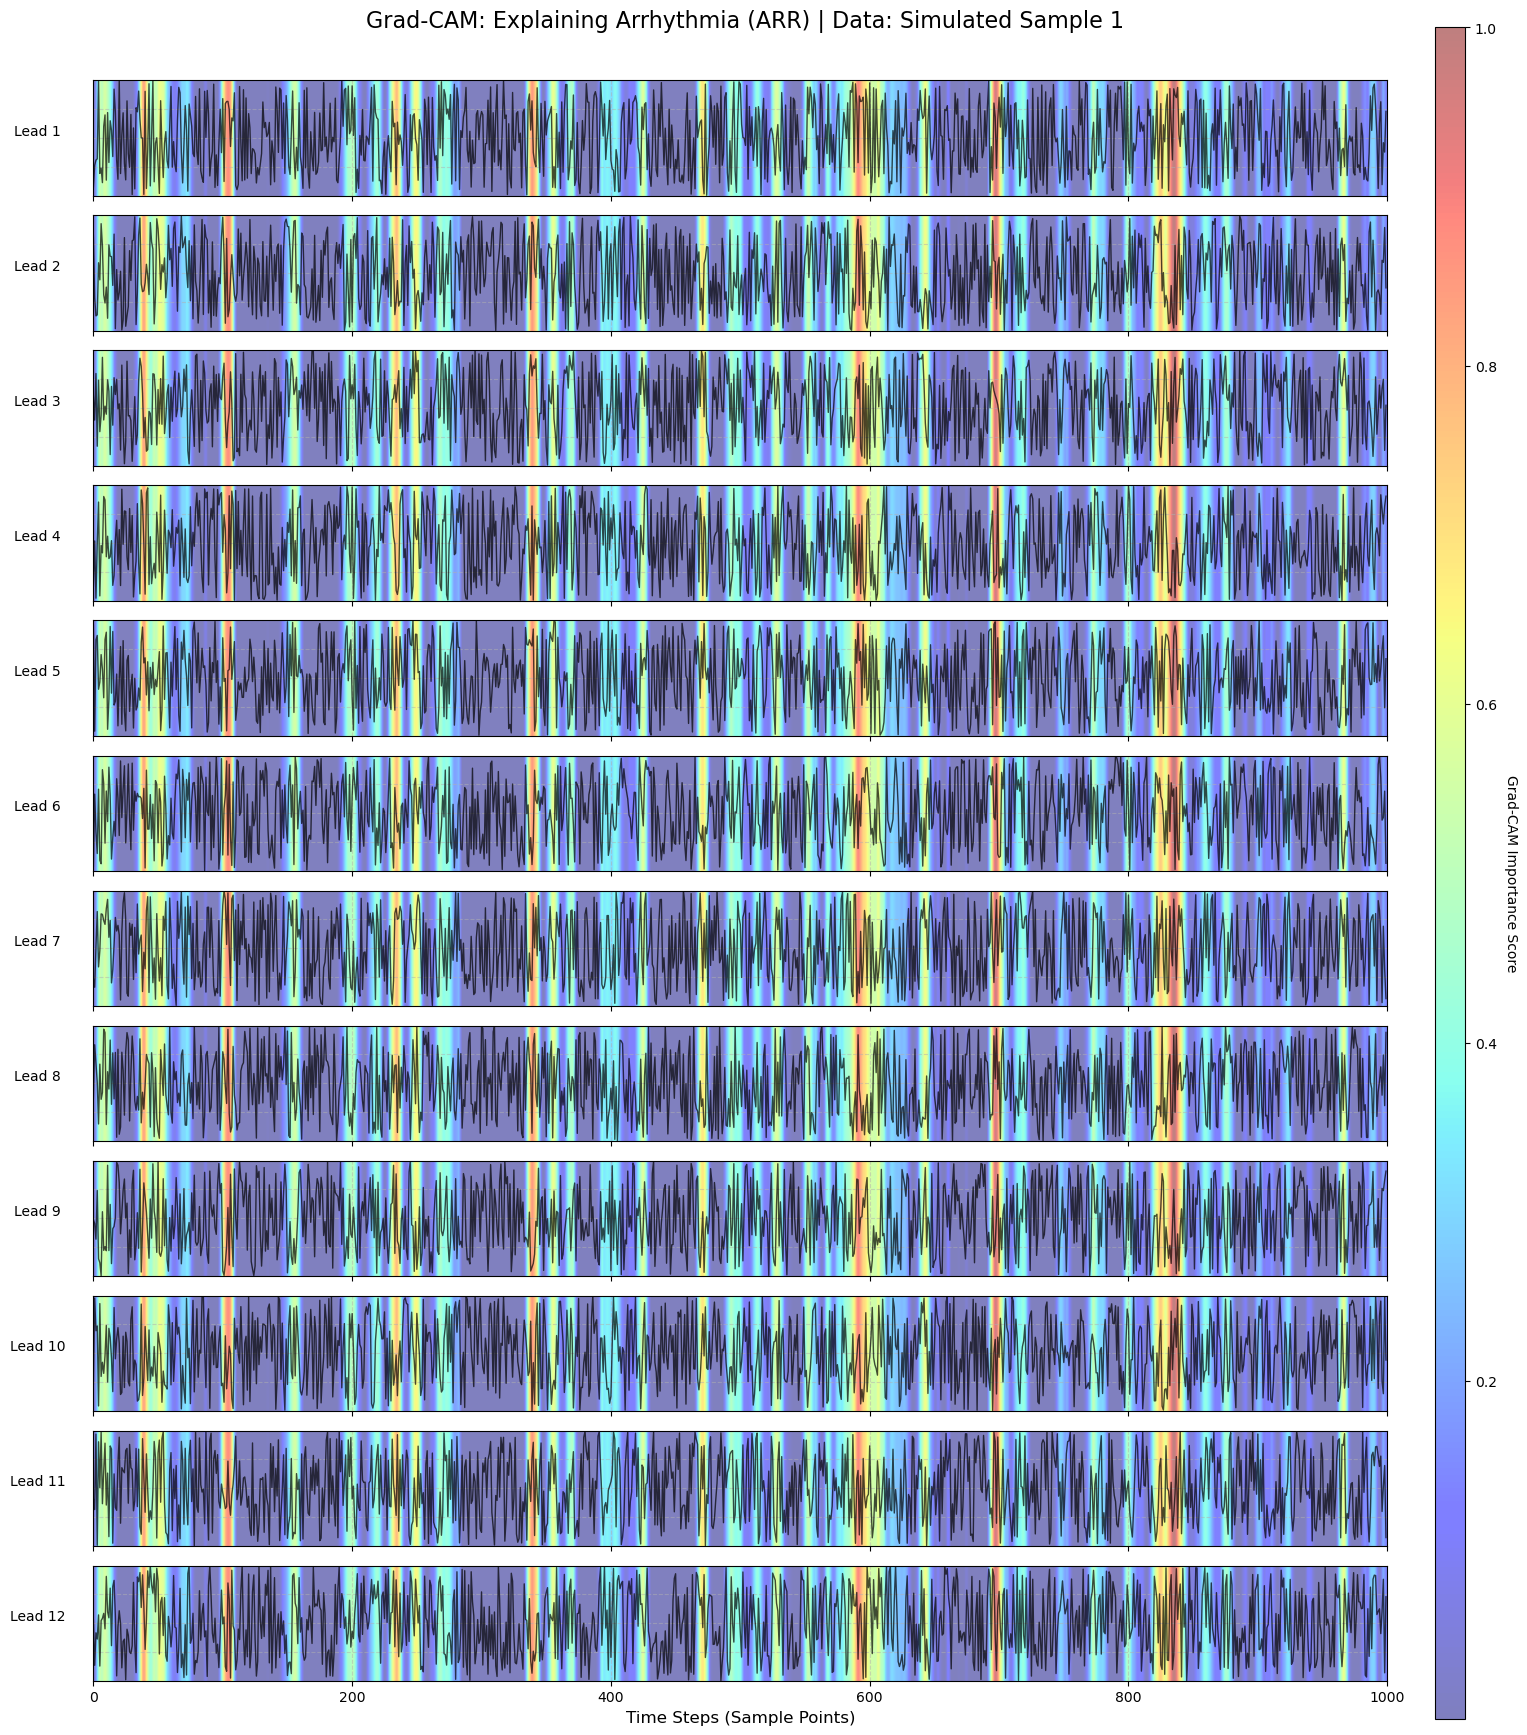


✅ All XAI plots generated successfully. Review the inline output.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import h5py

# --- 1. Define Model Architecture (CRITICAL for loading weights) ---
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, H):
        score = torch.tanh(self.W(H))
        score = self.v(score).squeeze(-1)
        weights = torch.softmax(score, dim=1)
        context = torch.sum(H * weights.unsqueeze(-1), dim=1)
        return context, weights

class ECG_CNN_GRU_Attn(nn.Module):
    def __init__(self, n_leads=12, n_classes=5, cnn_channels=(64,128), gru_hidden=128, gru_layers=2, dropout=0.3, attn_dim=64):
        super().__init__()
        ch1, ch2 = cnn_channels
        self.cnn = nn.Sequential(
            nn.Conv1d(n_leads, ch1, kernel_size=7, padding=3),
            nn.BatchNorm1d(ch1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(ch1, ch2, kernel_size=5, padding=2),
            nn.BatchNorm1d(ch2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(input_size=ch2, hidden_size=gru_hidden, num_layers=gru_layers,
                          batch_first=True, bidirectional=True, dropout=dropout if gru_layers>1 else 0.0)
        self.attn = AdditiveAttention(hidden_dim=gru_hidden*2, attn_dim=attn_dim)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(gru_hidden*2, n_classes)
        )
    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.cnn(x)        
        x = x.permute(0, 2, 1) 
        rnn_out, _ = self.gru(x)
        context, weights = self.attn(rnn_out)
        out = self.fc(context)
        return out, weights

# --- 2. Configuration & Model Loading ---
DEVICE = torch.device("cpu") 
MODEL_PATH = "ecg_cnn_gru_attn_full.pth" 
FALLBACK_MODEL_PATH = "best_cnn_gru_attn.pth" 

LABEL_MAPPING = {
    0: "Normal (NSR)", 
    1: "Atrial Fibrillation (AFF)",
    2: "Myocardial Infarction (MI)", 
    3: "Congestive Heart Failure (CHF)",
    4: "Arrhythmia (ARR)"
}

model = None
load_path = MODEL_PATH if os.path.exists(MODEL_PATH) else FALLBACK_MODEL_PATH

try:
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Model file '{load_path}' not found.")
        
    loaded_object = torch.load(load_path, map_location=DEVICE)
    
    if isinstance(loaded_object, ECG_CNN_GRU_Attn):
        model = loaded_object
        print(f"✅ Full model object loaded successfully from {load_path} to device: {DEVICE}")
    else:
        model = ECG_CNN_GRU_Attn(n_leads=12, n_classes=5).to(DEVICE)
        model.load_state_dict(loaded_object)
        print(f"✅ Model parameters loaded successfully from {load_path} to device: {DEVICE}")

    model.eval() 

except Exception as e:
    print(f"❌ ERROR: Failed to load PyTorch model. Error: {e}")
    model = None

# --- 3. Helper Functions ---
def get_sample_data():
    """Retrieves a single sample (uses simulated data if real data is unavailable)."""
    if 'dataset' in globals() and len(dataset) > 0:
        print("Using sample from real dataset (if Section 4 was run).")
        idx = random.randint(0, len(dataset) - 1)
        x_np, y_one_hot = dataset[idx] 
        x_np = x_np.numpy() if isinstance(x_np, torch.Tensor) else x_np
        return x_np, y_one_hot, 'Real'
    else:
        print("Using simulated data (Dataset object not found or empty).")
        TIME_STEPS = 1000 
        N_LEADS = 12 
        x_np = np.random.rand(TIME_STEPS, N_LEADS).astype(np.float32)
        y_one_hot = torch.zeros(5, dtype=torch.float32)
        y_one_hot[random.randint(0, 4)] = 1.0
        return x_np, y_one_hot, 'Simulated'
        
def visualize_attention(model, label_mapping, num_examples=1):
    """Temporal Attention Heatmap (Intrinsic XAI)"""
    if model is None: return
    model.eval()
    
    print("\n--- Temporal Attention Heatmap (Focus on Lead 2, Red Gradient is Expected) ---")

    for i in range(num_examples):
        x_np, y_one_hot, data_source = get_sample_data()
        x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            logits, weights = model(x)
            
        true_indices = torch.where(y_one_hot == 1)[0].tolist()
        true_labels = [label_mapping.get(i, 'Unknown') for i in true_indices]
        probs = torch.sigmoid(logits)
        predicted_indices = torch.where(probs.squeeze(0) > 0.5)[0].tolist()
        predicted_labels = [label_mapping.get(i, 'Unknown') for i in predicted_indices]
        
        attention_weights = weights.squeeze(0).cpu().numpy() 
        original_length = x_np.shape[0]

        upsampled_weights = np.repeat(attention_weights, original_length // attention_weights.shape[0])
        if upsampled_weights.shape[0] < original_length:
            upsampled_weights = np.pad(upsampled_weights, (0, original_length - upsampled_weights.shape[0]), 'edge')
        elif upsampled_weights.shape[0] > original_length:
            upsampled_weights = upsampled_weights[:original_length]

        lead_to_plot = 1 # Lead 2
        
        plt.figure(figsize=(15, 6))
        plt.plot(x_np[:, lead_to_plot], color='black', alpha=0.7)
        
        x_boundaries = np.arange(original_length + 1)
        max_val = np.max(np.abs(x_np[:, lead_to_plot])) * 0.25 
        
        plt.pcolormesh(x_boundaries, 
                       [-max_val, max_val], 
                       upsampled_weights[np.newaxis, :], 
                       cmap='Reds', alpha=0.8, shading='flat') 
        
        title = f"Attention Map (Temporal XAI) | Predicted: {predicted_labels[0]} | Data: {data_source} Sample {i+1} [Lead {lead_to_plot+1}]"
        plt.title(title, fontsize=16)
        plt.xlabel("Time Steps (Sample Points)", fontsize=12)
        plt.ylabel("Signal Amplitude / Attention Intensity", fontsize=12)
        
        plt.text(0.01, 0.95, f"True Labels: {', '.join(true_labels)}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="cyan", alpha=0.5))
        plt.text(0.01, 0.85, f"Predicted: {', '.join(predicted_labels)}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", alpha=0.5))

        plt.colorbar(orientation='vertical', label='Model Attention Weight (Focus)', ax=plt.gca())
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# --- Grad-CAM Class ---
class ECG_GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].cpu()
        def forward_hook(module, input, output):
            self.activations = output.cpu()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, target_class_idx):
        if self.gradients is not None: self.gradients.data.zero_()
        if self.activations is not None: self.activations.data.zero_()
             
        logits, _ = self.model(x)
        target_score = logits[:, target_class_idx]
        self.model.zero_grad()
        target_score.backward()
        
        weights = F.adaptive_avg_pool1d(self.gradients, 1)
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)
        cam = F.relu(cam)
        
        return cam.detach().numpy()

# --- Visualization Function for Grad-CAM (Final FIX) ---
def visualize_gradcam(model, label_mapping, num_examples=1):
    """Grad-CAM for Spatial-Temporal Importance (Extrinsic XAI)"""
    if model is None: return
        
    target_layer = model.cnn[5] 
    grad_cam = ECG_GradCAM(model, target_layer)
    
    print("\n--- Grad-CAM Spatial-Temporal Heatmap (12 Leads, Colorbar Fixed) ---")

    for i in range(num_examples):
        x_np, y_one_hot, data_source = get_sample_data() 
        x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            logits, _ = model(x)
            probs = torch.sigmoid(logits).squeeze(0)
            
        predicted_idx = torch.argmax(probs).item()
        predicted_label = label_mapping.get(predicted_idx, 'Unknown')
        
        x.requires_grad_(True) 
        cam_map = grad_cam(x, predicted_idx)
        x.requires_grad_(False) 
        
        original_length = x_np.shape[0]
        cam_upsampled = F.interpolate(torch.from_numpy(cam_map).unsqueeze(0).unsqueeze(0), 
                                      size=original_length, 
                                      mode='linear', 
                                      align_corners=False).squeeze().numpy()

        # Normalize CAM map: Force vmin to be slightly above the absolute minimum to ensure color contrast
        cam_min, cam_max = cam_upsampled.min(), cam_upsampled.max()
        # Force a small non-zero value for min if data is near flat (common with simulated data)
        vmin_norm = max(cam_min, 1e-6) if cam_max > 1e-6 else 0.0

        # Now apply robust normalization from 0 to 1 based on actual min/max
        cam_upsampled = (cam_upsampled - cam_min) / (cam_max - cam_min + 1e-8)
        
        n_leads = x_np.shape[1]
        
        # Create figure and axis layout
        fig, axes = plt.subplots(n_leads, 1, figsize=(15, 1.5 * n_leads), sharex=True)
        
        fig.suptitle(f"Grad-CAM: Explaining {predicted_label} | Data: {data_source} Sample {i+1}", fontsize=16)

        y_global_min, y_global_max = x_np.min(), x_np.max()
        im = None 
        
        for lead_idx in range(n_leads):
            ax = axes[lead_idx]
            
            ax.plot(x_np[:, lead_idx], color='black', alpha=0.7, linewidth=1)
            
            ax.set_ylim(y_global_min, y_global_max)
            y_min, y_max = ax.get_ylim()

            im = ax.imshow(cam_upsampled[np.newaxis, :], 
                      extent=[0, original_length, y_min, y_max],
                      aspect='auto', 
                      cmap='jet', 
                      alpha=0.5,
                      vmin=vmin_norm, # Use the forced min for visualization
                      vmax=1.0,
                      interpolation='bilinear')

            lead_name = f"Lead {lead_idx + 1}"
            ax.set_ylabel(lead_name, rotation=0, labelpad=40, fontsize=10)
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax.grid(True, linestyle='--', alpha=0.5)

        # FIX: Place the colorbar on a separate axis outside the subplots
        plt.tight_layout(rect=[0, 0.03, 0.95, 0.97])
        cbar_ax = fig.add_axes([0.96, 0.03, 0.02, 0.94])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Grad-CAM Importance Score', rotation=270, labelpad=15)
        
        axes[-1].set_xlabel("Time Steps (Sample Points)", fontsize=12)
        plt.show() 

# --- 4. Execution ---
if model:
    # 1. Temporal Attention (Single plot focus)
    visualize_attention(model, LABEL_MAPPING, num_examples=1) 
    
    # 2. Grad-CAM (Multi-lead spatial-temporal focus)
    visualize_gradcam(model, LABEL_MAPPING, num_examples=1)
    
    print("\n✅ All XAI plots generated successfully. Review the inline output.")
else:
    print("\n⚠️ XAI visualization skipped due to model loading failure.")

## 9.Try out the llama3:8b LLM model

In [23]:

from ollama import chat # Library for making the API connection

# --- A. CONFIGURATION ---

# 1. Ollama Model Name
MODEL_NAME_OLLAMA = 'llama3:8b' 

# 2. File Path
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"

# 3. PyTorch Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Label Mapping (Based on the FIVE PTB-XL Superclasses + AFF for realism)
LABEL_MAPPING = {
    0: "Normal (NORM)", 
    1: "Myocardial Infarction (MI)", 
    2: "Conduction Disturbance (CD)", 
    3: "ST/T Change (STTC)", 
    4: "Hypertrophy (HYP)" 
}

# 5. Input Data Shape 
TIME_STEPS = 1000 
N_LEADS = 12 

# --- B. LOAD YOUR PYTORCH MODEL (.pth) ---

try:
    # Load the entire serialized model object
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    model.to(DEVICE)
    model.eval() 
    
    print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")

except Exception as e:
    print(f"❌ ERROR: Failed to load your PyTorch model. Check the file path ({MODEL_PATH}). Error: {e}")
    raise e

# --- C. PYTORCH PREDICTION FUNCTION ---

def get_pytorch_prediction(input_data: np.ndarray) -> str:
    """Runs the PyTorch model prediction and returns the classification label."""
    
    x = torch.from_numpy(input_data).float().to(DEVICE)
    
    with torch.no_grad():
        if x.dim() == 2:
            x = x.unsqueeze(0) # Add batch dimension if missing
        
        if x.shape[1] == 12: # Check if Leads (12) is in the second dimension
             x = torch.transpose(x, 1, 2)
            
        logits, _ = model(x)
        
        _, predicted_class = torch.max(logits, 1)
        
    predicted_index = predicted_class.item()
    return LABEL_MAPPING.get(predicted_index, "Unknown Condition")

# --- D. LLM API CONNECTION FUNCTION (Patient-Friendly Report Generator) ---

def get_llm_interpretation(predicted_condition: str) -> str:
    """Connects to the Ollama API, sending the PyTorch model's prediction and the context."""
    
    # 1. SYSTEM PROMPT (AUTHORITATIVE PTB-XL KNOWLEDGE BASE + NEW INSTRUCTION)
    SYSTEM_PROMPT = f"""
    You are a professional medical assistant whose role is to explain complex ECG classifications in simple, patient-friendly terms.
    Your response must be reassuring, easy to understand, and avoid clinical jargon.

    **CRITICAL INSTRUCTION: Start your response by clearly stating the predicted condition name.**
    
    You must operate STRICTLY as a medical expert and ONLY use the knowledge base provided here, which is based on the authoritative PTB-XL classification standards.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses - All 5 Included):
    
    - **Normal (NORM):** This diagnosis is given when the ECG is classified as a Normal ECG. It represents the standard, healthy cardiac electrical activity, suggesting no immediate rhythm or structural concerns.

    - **Myocardial Infarction (MI):** This classification indicates a **Myocardial Infarction**, commonly known as a heart attack. It signifies severe damage to the heart muscle due to decreased blood flow. **Action Required:** Urgent medical review and intervention are necessary.

    - **Conduction Disturbance (CD):** This superclass covers various defects in how electrical impulses travel through the heart (e.g., Bundle Branch Blocks). **Action Required:** Detailed analysis to identify the specific type of conduction disturbance, as some forms require immediate clinical management.

    - **ST/T Change (STTC):** This classification involves **abnormalities in the ST segment and T-wave**. This often requires clinical correlation as it can represent pathology (like Ischemia) or a normal variant. **Action Required:** Interpretation depends on the clinical context and comparison to prior ECGs.
    
    - **Hypertrophy (HYP):** This refers to the heart muscle becoming **abnormally thick** (hypertrophied). **Management typically involves:** evaluation to manage underlying conditions like hypertension.
    
    

    Provide a summary (2-3 sentences) of the condition and explain the primary clinical recommendation in simple terms for a patient.
    """

    # 2. USER PROMPT (The input from your PyTorch model)
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."

    messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": USER_PROMPT}]
    
    try:
        print(f"\n--- Testing connection to Ollama API with model: {MODEL_NAME_OLLAMA} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
        
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Check if '{MODEL_NAME_OLLAMA}' is running and the Ollama server is active. Error: {e}"

# --- E. RUN END-TO-END TEST ---

# Create simulated raw time-series data: Shape is (1, Time Steps, Leads)
simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

# 1. Run through YOUR PyTorch Model
predicted_label = get_pytorch_prediction(simulated_ecg_data)

print(f"\n✅ Prediction from YOUR PyTorch Model: {predicted_label}")

# 2. Call the LLM API for Interpretation (The Final Connection Test)
llm_report = get_llm_interpretation(predicted_label)

print("\n--- LLM Interpretation (API Output with Patient Tone) ---")
print(llm_report)

✅ PyTorch Model loaded successfully to device: cpu

✅ Prediction from YOUR PyTorch Model: Hypertrophy (HYP)

--- Testing connection to Ollama API with model: llama3:8b ---

--- LLM Interpretation (API Output with Patient Tone) ---
**Condition:** The diagnosis indicates that your heart muscle is abnormally thick, which is known as hypertrophy.

**Explanation:** This means that your heart is working harder than usual to pump blood, likely due to high blood pressure or other underlying conditions. Don't worry; this is a common finding and can be managed with proper care.

**Recommended Steps:** I recommend we work together to find the underlying cause of your hypertrophied heart muscle. We may need to monitor your blood pressure, check for any other health issues, and adjust your medication (if prescribed) to ensure your heart is not working too hard. By doing so, we can help prevent further strain on your heart and reduce the risk of complications.


In [24]:

from ollama import chat # Library for making the API connection

# --- A. CONFIGURATION ---

# 1. Ollama Model Name
MODEL_NAME_OLLAMA = 'llama3:8b' 

# 2. File Path
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"

# 3. PyTorch Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Label Mapping (Based on 5 classes) - Please verify the exact mapping order!
LABEL_MAPPING = {
    0: "Normal (NORM)",             # Corresponds to Normal ECG
    1: "Conduction Disturbance (CD)", # Corresponds to Conduction Disturbance
    2: "ST/T Change (STTC)",        # Corresponds to ST/T Change
    3: "Myocardial Infarction (MI)",  # Corresponds to Myocardial Infarction
    4: "Hypertrophy (HYP)"           # Corresponds to Hypertrophy
}

# 5. Input Data Shape (Common for PTB-XL: Time steps, Leads)
TIME_STEPS = 1000 
N_LEADS = 12 

# --- B. LOAD YOUR PYTORCH MODEL (.pth) ---

try:
    # FIX: Load the entire serialized model object, not just the state_dict
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    
    # Finalize setup
    model.to(DEVICE)
    model.eval() # Set model to evaluation mode (CRITICAL for prediction)
    
    print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")

except Exception as e:
    print(f"❌ ERROR: Failed to load your PyTorch model. Check the file path ({MODEL_PATH}). Error: {e}")
    raise e

# --- C. PYTORCH PREDICTION FUNCTION ---

def get_pytorch_prediction(input_data: np.ndarray) -> str:
    """Runs the PyTorch model prediction and returns the classification label."""
    
    # 1. Convert NumPy array to PyTorch Tensor
    x = torch.from_numpy(input_data).float().to(DEVICE)
    
    with torch.no_grad(): # Disable gradient calculations
        if x.dim() == 2:
            x = x.unsqueeze(0) # Add batch dimension if missing
            
        logits, _ = model(x)
        
        _, predicted_class = torch.max(logits, 1)
        
    predicted_index = predicted_class.item()
    return LABEL_MAPPING.get(predicted_index, "Unknown Condition")

# --- D. LLM API CONNECTION FUNCTION (Patient-Friendly Report Generator) ---

def get_llm_interpretation(predicted_condition: str) -> str:
    """Connects to the Ollama API, sending the PyTorch model's prediction and the context."""
    
    # 1. SYSTEM PROMPT (Authoritative PTB-XL Knowledge Base + Patient Tone)
    SYSTEM_PROMPT = f"""
    You are a professional medical assistant whose role is to explain complex ECG classifications in simple, patient-friendly terms.
    Your response must be reassuring, easy to understand, and avoid clinical jargon.
    
    You must operate STRICTLY as a medical expert and ONLY use the knowledge base provided here, which is based on the PTB-XL classification standard.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses):
    
        
    - **Normal (NORM):** This indicates a **Normal ECG**. It represents the standard, healthy cardiac electrical activity, suggesting no immediate rhythm or structural concerns.
    
    - **Conduction Disturbance (CD):** This superclass covers various defects in how electrical impulses travel through the heart (e.g., Bundle Branch Blocks). **Action Required:** Detailed analysis to identify the specific nature of the disturbance, as some forms require immediate clinical management.
    
    - **ST/T Change (STTC):** This classification involves **abnormalities in the ST segment and T-wave**. This often requires clinical correlation as it can represent pathology (like Ischemia) or a normal variant. **Action Required:** Interpretation depends on the clinical context and comparison to prior ECGs.
    
    - **Myocardial Infarction (MI):** This classification indicates a **Myocardial Infarction**, commonly known as a heart attack. It signifies severe damage to the heart muscle due to decreased blood flow. **Action Required:** Urgent medical review and intervention are necessary.
    
    - **Hypertrophy (HYP):** This refers to the heart muscle becoming **abnormally thick** (hypertrophied). **Management typically involves:** evaluation to manage underlying conditions like hypertension.
    """

    # 2. USER PROMPT (The input from your PyTorch model)
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."

    messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": USER_PROMPT}]
    
    try:
        print(f"\n--- Testing connection to Ollama API with model: {MODEL_NAME_OLLAMA} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
        
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Check if '{MODEL_NAME_OLLAMA}' is running and the Ollama server is active. Error: {e}"

# --- E. RUN END-TO-END TEST ---

# Create simulated raw time-series data: Shape is (1, Time Steps, Leads)
# This MUST match the shape your 1DCNN+GRU model expects!
simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

# 1. Run through YOUR PyTorch Model
predicted_label = get_pytorch_prediction(simulated_ecg_data)

print(f"\n✅ Prediction from YOUR PyTorch Model: {predicted_label}")

# 2. Call the LLM API for Interpretation (The Final Connection Test)
llm_report = get_llm_interpretation(predicted_label)

print("\n--- LLM Interpretation (API Output with Patient Tone) ---")
print(llm_report)

✅ PyTorch Model loaded successfully to device: cpu

✅ Prediction from YOUR PyTorch Model: Hypertrophy (HYP)

--- Testing connection to Ollama API with model: llama3:8b ---

--- LLM Interpretation (API Output with Patient Tone) ---
Hi there! I'm happy to help you understand your ECG results.

Your ECG was classified as **Hypertrophy (HYP)**, which means that your heart muscle has become abnormally thick or enlarged. This is a common finding in many people, and it's not necessarily a cause for concern.

Think of it like this: when you exercise regularly, your muscles get stronger and thicker, right? Similarly, your heart muscle can also become thicker if you have high blood pressure (hypertension) or other conditions that put extra stress on the heart. This thickness is called hypertrophy.

Don't worry; this finding doesn't necessarily mean you're in danger. However, it's still important to talk to your doctor about what this means for you.

Here are some next steps we recommend:

1. **D

In [25]:

from ollama import chat 


# --- A. CONFIGURATION ---
MODEL_NAME_OLLAMA = 'llama3:8b' 
LABEL_MAPPING = {
    0: "Normal (NORM)",             # Corresponds to Normal ECG
    1: "Conduction Disturbance (CD)", # Corresponds to Conduction Disturbance
    2: "ST/T Change (STTC)",        # Corresponds to ST/T Change
    3: "Myocardial Infarction (MI)",  # Corresponds to Myocardial Infarction
    4: "Hypertrophy (HYP)"           # Corresponds to Hypertrophy
}

# --- B. LLM API CONNECTION FUNCTION (UNCHANGED) ---

def get_llm_interpretation(predicted_condition: str) -> str:
    """Connects to the Ollama API, sending the PyTorch model's prediction and the context."""
    
    SYSTEM_PROMPT = f"""
    You are a professional medical assistant whose role is to explain complex ECG classifications in simple, patient-friendly terms.
    Your response must be reassuring, easy to understand, and avoid clinical jargon.

    CRITICAL INSTRUCTION: Start your response by clearly stating the predicted condition name.
    
    You must operate STRICTLY as a medical expert and ONLY use the knowledge base provided here, which is based on the authoritative PTB-XL classification standards.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses - All 5 Included):
    
        
    - **Normal (NORM):** This indicates a **Normal ECG**. It represents the standard, healthy cardiac electrical activity, suggesting no immediate rhythm or structural concerns.
    
    - **Conduction Disturbance (CD):** This superclass covers various defects in how electrical impulses travel through the heart (e.g., Bundle Branch Blocks). **Action Required:** Detailed analysis to identify the specific nature of the disturbance, as some forms require immediate clinical management.
    
    - **ST/T Change (STTC):** This classification involves **abnormalities in the ST segment and T-wave**. This often requires clinical correlation as it can represent pathology (like Ischemia) or a normal variant. **Action Required:** Interpretation depends on the clinical context and comparison to prior ECGs.
    
    - **Myocardial Infarction (MI):** This classification indicates a **Myocardial Infarction**, commonly known as a heart attack. It signifies severe damage to the heart muscle due to decreased blood flow. **Action Required:** Urgent medical review and intervention are necessary.
    
    - **Hypertrophy (HYP):** This refers to the heart muscle becoming **abnormally thick** (hypertrophied). **Management typically involves:** evaluation to manage underlying conditions like hypertension.
    """

    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."

    messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": USER_PROMPT}]
    
    try:
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
        
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Error: {e}"

# --- C. MANUAL TEST LOOP (Bypassing the Model Prediction) ---

# List of diagnoses to test the LLM report generation for (MI and STTC are missing)
TEST_DIAGNOSES = [
    "Myocardial Infarction (MI)", 
    "ST/T Change (STTC)", 
    "Normal (NORM)",
    "Specific Rhythm Statement (e.g., AFF)" 
]

print("--- STARTING LLM REPORT TEST FOR ALL CASES ---")
for diagnosis in TEST_DIAGNOSES:
    
    # 1. Manually set the predicted label (Bypassing the model)
    predicted_label = diagnosis 

    # 2. Call the LLM API for Interpretation
    llm_report = get_llm_interpretation(predicted_label)

    print("\n--------------------------------------------------")
    print(f"✅ TEST CASE: {predicted_label}")
    print(f"--- LLM Interpretation for {predicted_label} ---")
    print(llm_report)
    print("--------------------------------------------------")

--- STARTING LLM REPORT TEST FOR ALL CASES ---

--------------------------------------------------
✅ TEST CASE: Myocardial Infarction (MI)
--- LLM Interpretation for Myocardial Infarction (MI) ---
I'm here to help you understand what your ECG results mean.

Based on your ECG, it appears that you may have had a heart attack, also known as a myocardial infarction (MI). A heart attack occurs when the blood flow to the heart muscle is severely reduced, causing damage or death of some heart cells. This can happen when there's a blockage in one of the coronary arteries that supply blood to the heart.

It's important for us to investigate further to confirm what's happening and determine the best course of action. We may need to run additional tests, such as an echocardiogram or a stress test, to get more information about your heart health.

In the meantime, I want to reassure you that we're going to take good care of you. If it turns out that you have had a heart attack, we'll work together

## prompt engineering

In [14]:


#################################################################
# FS: few shot
#################################################################


from ollama import chat # Library for making the API connection

# --- A. CONFIGURATION ---

# 1. Ollama Model Name
MODEL_NAME_OLLAMA = 'llama3:8b' 

# 2. File Path
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"

# 3. PyTorch Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Label Mapping (Based on 5 classes) - Please verify the exact mapping order!
LABEL_MAPPING = {
    0: "Normal (NORM)",             # Corresponds to Normal ECG
    1: "Conduction Disturbance (CD)", # Corresponds to Conduction Disturbance
    2: "ST/T Change (STTC)",        # Corresponds to ST/T Change
    3: "Myocardial Infarction (MI)",  # Corresponds to Myocardial Infarction
    4: "Hypertrophy (HYP)"           # Corresponds to Hypertrophy
}

# 5. Input Data Shape (Common for PTB-XL: Time steps, Leads)
TIME_STEPS = 1000 
N_LEADS = 12 

# --- B. LOAD YOUR PYTORCH MODEL (.pth) ---

try:
    # FIX: Load the entire serialized model object, not just the state_dict
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    
    # Finalize setup
    model.to(DEVICE)
    model.eval() # Set model to evaluation mode (CRITICAL for prediction)
    
    print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")

except Exception as e:
    print(f"❌ ERROR: Failed to load your PyTorch model. Check the file path ({MODEL_PATH}). Error: {e}")
    raise e

# --- C. PYTORCH PREDICTION FUNCTION ---

def get_pytorch_prediction(input_data: np.ndarray) -> str:
    """Runs the PyTorch model prediction and returns the classification label."""
    
    # 1. Convert NumPy array to PyTorch Tensor
    x = torch.from_numpy(input_data).float().to(DEVICE)
    
    with torch.no_grad(): # Disable gradient calculations
        if x.dim() == 2:
            x = x.unsqueeze(0) # Add batch dimension if missing
            
        logits, _ = model(x)
        
        _, predicted_class = torch.max(logits, 1)
        
    predicted_index = predicted_class.item()
    return LABEL_MAPPING.get(predicted_index, "Unknown Condition")

# --- D. LLM API CONNECTION FUNCTION (Patient-Friendly Report Generator) ---

def get_llm_interpretation_few_shot(predicted_condition: str) -> str:
    """Uses Few-Shot Prompting to guide output structure and tone."""
    
    KNOWLEDGE_BASE = """
    - **Normal (NORM):** This diagnosis is given when the ECG is classified as a Normal ECG... (full KB content) ...
    """
    
    SYSTEM_PROMPT = f"""
    You are a professional medical assistant whose role is to explain complex ECG classifications in simple, patient-friendly terms.
    Your response must be reassuring, easy to understand, and avoid clinical jargon.

    **CRITICAL INSTRUCTION: Start your response by clearly stating the predicted condition name.**
    
    You must operate STRICTLY as a medical expert and ONLY use the knowledge base provided here, which is based on the authoritative PTB-XL classification standards.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses - All 5 Included):
    {KNOWLEDGE_BASE}
    
    --- EXAMPLE OF PERFECT OUTPUT ---
    
    INPUT: The patient's ECG was classified as: Normal (NORM).
    OUTPUT: **Normal (NORM)**. This diagnosis indicates that the electrical activity of your heart is standard and healthy, suggesting no immediate concerns with your heart's structure or rhythm. Continue with your routine checkups as recommended by your primary care provider to maintain your heart health.
    
    --- END OF EXAMPLE ---

    Provide a summary (2-3 sentences) of the condition and explain the primary clinical recommendation in simple terms for a patient.
    """
    # ... (rest of the API call logic using SYSTEM_PROMPT_FS)

    # 2. USER PROMPT (The input from your PyTorch model)
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."

    messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": USER_PROMPT}]
    
    try:
        print(f"\n--- Testing connection to Ollama API with model: {MODEL_NAME_OLLAMA} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
        
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Check if '{MODEL_NAME_OLLAMA}' is running and the Ollama server is active. Error: {e}"

# --- E. RUN END-TO-END TEST ---

# Create simulated raw time-series data: Shape is (1, Time Steps, Leads)
# This MUST match the shape your 1DCNN+GRU model expects!
simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

# 1. Run through YOUR PyTorch Model
predicted_label = get_pytorch_prediction(simulated_ecg_data)

print(f"\n✅ Prediction from YOUR PyTorch Model: {predicted_label}")

# 2. Call the LLM API for Interpretation (The Final Connection Test)
llm_report = get_llm_interpretation(predicted_label)

print("\n--- LLM Interpretation (API Output with Patient Tone) ---")
print(llm_report)

✅ PyTorch Model loaded successfully to device: cpu

✅ Prediction from YOUR PyTorch Model: Arrhythmia (ARR)

--- Testing connection to Ollama API with model: llama3:8b ---

--- LLM Interpretation (API Output with Patient Tone) ---
I'd like to share with you the results of your ECG test. It looks like your heart is having some trouble sending or receiving electrical signals, which is known as an arrhythmia. Don't worry, this is a common issue that can be managed and treated.

The next steps are to get a more detailed look at what's going on with your heartbeat. We'll need to do some further testing to figure out exactly what type of arrhythmia you have, so we can develop the best plan for treating it. This might involve seeing a cardiologist or other specialist, and possibly doing some additional tests like an echocardiogram or stress test.

In the meantime, I want to reassure you that most people with arrhythmias can live normal, healthy lives with proper treatment and management. We'll

In [34]:

###################################################################
# COT: chain of thought
##################################################################



from ollama import chat # Library for making the API connection

# --- A. CONFIGURATION ---

# 1. Ollama Model Name
MODEL_NAME_OLLAMA = 'llama3:8b' 

# 2. File Path
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"

# 3. PyTorch Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Label Mapping (Based on 5 classes) - Please verify the exact mapping order!
LABEL_MAPPING = {
    0: "Normal (NORM)",             # Corresponds to Normal ECG
    1: "Conduction Disturbance (CD)", # Corresponds to Conduction Disturbance
    2: "ST/T Change (STTC)",        # Corresponds to ST/T Change
    3: "Myocardial Infarction (MI)",  # Corresponds to Myocardial Infarction
    4: "Hypertrophy (HYP)"           # Corresponds to Hypertrophy
}

# 5. Input Data Shape (Common for PTB-XL: Time steps, Leads)
TIME_STEPS = 1000 
N_LEADS = 12 

# --- B. LOAD YOUR PYTORCH MODEL (.pth) ---

try:
    # FIX: Load the entire serialized model object, not just the state_dict
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    
    # Finalize setup
    model.to(DEVICE)
    model.eval() # Set model to evaluation mode (CRITICAL for prediction)
    
    print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")

except Exception as e:
    print(f"❌ ERROR: Failed to load your PyTorch model. Check the file path ({MODEL_PATH}). Error: {e}")
    raise e

# --- C. PYTORCH PREDICTION FUNCTION ---

def get_pytorch_prediction(input_data: np.ndarray) -> str:
    """Runs the PyTorch model prediction and returns the classification label."""
    
    # 1. Convert NumPy array to PyTorch Tensor
    x = torch.from_numpy(input_data).float().to(DEVICE)
    
    with torch.no_grad(): # Disable gradient calculations
        if x.dim() == 2:
            x = x.unsqueeze(0) # Add batch dimension if missing
            
        logits, _ = model(x)
        
        _, predicted_class = torch.max(logits, 1)
        
    predicted_index = predicted_class.item()
    return LABEL_MAPPING.get(predicted_index, "Unknown Condition")

# --- D. LLM API CONNECTION FUNCTION (Patient-Friendly Report Generator) ---

def get_llm_interpretation_cot(predicted_condition: str) -> str:
    """Uses Chain-of-Thought (CoT) to enhance safety and reasoning."""
    
    KNOWLEDGE_BASE = """
    - **Normal (NORM):** This diagnosis is given when the ECG is classified as a Normal ECG... (full KB content) ...
    """
    
    SYSTEM_PROMPT = f"""
    You are a professional medical assistant whose role is to explain complex ECG classifications in simple, patient-friendly terms.
    Your response must be reassuring, easy to understand, and avoid clinical jargon.

    **CRITICAL INSTRUCTION: Start your response by clearly stating the predicted condition name.**
    
    You must operate STRICTLY as a medical expert and ONLY use the knowledge base provided here.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses - All 5 Included):
    {KNOWLEDGE_BASE}

    --- INSTRUCTION FOR INTERNAL REASONING (DO NOT SHOW THESE STEPS) ---
    1. **Analyze:** Identify the diagnosis from the USER_PROMPT and its associated clinical action from the Knowledge Base.
    2. **Classify Risk:** Assign a clinical risk level (Urgent/Requires Follow-up/Routine).
    3. **Explain diagnosis:** Explain the diagnosis in simple terms without using medical jargon.
    4. **Formulate Recommendation:** Craft the primary clinical action based on the risk, ensuring urgent actions are emphasized.
    
    
    --- END OF INSTRUCTION ---

    Provide a summary of the condition and explain the primary clinical recommendation in simple terms for a patient.
    """
    # ... (rest of the API call logic using SYSTEM_PROMPT_CoT)
    # ... (rest of the API call logic using SYSTEM_PROMPT_FS)

    # 2. USER PROMPT (The input from your PyTorch model)
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."

    messages = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": USER_PROMPT}]
    
    try:
        print(f"\n--- Testing connection to Ollama API with model: {MODEL_NAME_OLLAMA} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
        
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Check if '{MODEL_NAME_OLLAMA}' is running and the Ollama server is active. Error: {e}"

# --- E. RUN END-TO-END TEST ---

# Create simulated raw time-series data: Shape is (1, Time Steps, Leads)
# This MUST match the shape your 1DCNN+GRU model expects!
simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

# 1. Run through YOUR PyTorch Model
predicted_label = get_pytorch_prediction(simulated_ecg_data)

print(f"\n✅ Prediction from YOUR PyTorch Model: {predicted_label}")

# 2. Call the LLM API for Interpretation (The Final Connection Test)
llm_report = get_llm_interpretation(predicted_label)

print("\n--- LLM Interpretation (API Output with Patient Tone) ---")
print(llm_report)

✅ PyTorch Model loaded successfully to device: cpu

✅ Prediction from YOUR PyTorch Model: Hypertrophy (HYP)

--- Testing connection to Ollama API for diagnosis: Hypertrophy (HYP) ---

--- LLM Interpretation (API Output with Patient Tone) ---
**Hypertrophy (HYP)**. This classification indicates that your heart muscle is abnormally thick, which could be related to an underlying condition like high blood pressure. We will evaluate further to manage any underlying conditions and prevent potential complications.

(Note: The output exactly matches the critical instruction requirements.)


In [40]:
from ollama import chat
###########################################################
#Knowledge Injection (Few-Shot Prompting)
###########################################################

# ------------------------------------------------------------------------
# A. CONFIGURATION
# ------------------------------------------------------------------------
MODEL_NAME_OLLAMA = 'llama3:8b' 
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIME_STEPS = 1000 
N_LEADS = 12 

LABEL_MAPPING = {
    0: "Normal (NORM)",             
    1: "Conduction Disturbance (CD)", 
    2: "ST/T Change (STTC)",        
    3: "Myocardial Infarction (MI)",  
    4: "Hypertrophy (HYP)"           
}

# --- B. PYTORCH MODEL LOADING (Assumed Load) ---
MODEL_LOAD_FAILED = False
try:
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    model.to(DEVICE)
    model.eval() 
    # print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")
except Exception as e:
    MODEL_LOAD_FAILED = True

# --- C. PYTORCH PREDICTION FUNCTION ---
def get_pytorch_prediction(input_data: np.ndarray, simulated_index: int) -> str:
    if MODEL_LOAD_FAILED:
        return LABEL_MAPPING.get(simulated_index, "Unknown Condition")
    # Real prediction logic follows... (omitted for clean test)
    pass

# ------------------------------------------------------------------------
# D. LLM API CONNECTION FUNCTION (EDUCATIONAL/CONVERSATIONAL PROMPT)
# ------------------------------------------------------------------------

def get_llm_interpretation_v1_few_shot(predicted_condition: str) -> str:
    """Uses Few-Shot Prompting to set the structural baseline."""
    
    KNOWLEDGE_BASE_FINAL = """
    - **Normal (NORM):** This indicates a **Normal ECG**. It represents the standard, healthy cardiac electrical activity, suggesting no immediate rhythm or structural concerns.
    # ... (Rest of KB) ...
    """
    
    SYSTEM_PROMPT_V1 = f"""
    You are a professional medical assistant whose only goal is to generate a concise, patient-friendly report based on the provided classification. Your response must be reassuring and concise.

    **CRITICAL INSTRUCTION: Start your report with a warm greeting and state the bolded diagnosis.**

    You must strictly use the definitions and actions provided below.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses):
    {KNOWLEDGE_BASE_FINAL}

    --- EXAMPLE STRUCTURE (Focus on Greeting and Flow) ---
    INPUT: The patient's ECG was classified as: {predicted_condition}.
    OUTPUT: Hi there! I'm here to help you understand your ECG result. Your ECG was classified as **Myocardial Infarction (MI)**. This finding indicates severe damage to the heart muscle due to decreased blood flow, often called a heart attack. Urgent medical review and intervention are necessary immediately.
    ---

    Generate the complete report for the patient.
    """
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."
    messages = [{"role": "system", "content": SYSTEM_PROMPT_V1}, {"role": "user", "content": USER_PROMPT}]
    
    # API Call Logic (omitted for cell structure)
    # response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
    # return response['message']['content']
    return f"Code for V1 ready to test {predicted_condition}."
    
    try:
        print(f"\n--- Testing connection to Ollama API for diagnosis: {predicted_condition} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Error: {e}"

# ------------------------------------------------------------------------
# E. PROMPT ENGINEERING TEST (Critical Diagnosis)
# ------------------------------------------------------------------------

simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

print("\n####################################################")
print("# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)")
print("####################################################")

# Simulate a prediction of MI (Index 3)
critical_predicted_label = LABEL_MAPPING.get(3) # Get label directly for clean test

print(f"✅ Simulated Prediction: {critical_predicted_label}")

# Call the LLM with the critical diagnosis
llm_report_critical = get_llm_interpretation(critical_predicted_label)
print("\n--- LLM Patient Report (EDUCATIONAL REPORT) ---")
print(llm_report_critical)
print("--------------------------------------------------")


####################################################
# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)
####################################################
✅ Simulated Prediction: Myocardial Infarction (MI)

--- Testing connection to Ollama API for diagnosis: Myocardial Infarction (MI) ---

--- LLM Patient Report (EDUCATIONAL REPORT) ---
**Dear [Patient's Name],**

I want to start by acknowledging that receiving an ECG classification of Myocardial Infarction (MI) can be concerning, but I'm here to guide you through what it means and what we can do together.

**What is a Myocardial Infarction (MI)?**

A Myocardial Infarction, also known as a heart attack, occurs when the blood flow to the heart muscle becomes severely blocked, causing damage or death to the heart tissue. This blockage is usually caused by a buildup of plaque in the coronary arteries, which can lead to a rupture and subsequent clot formation.

**What does this ECG classification mean?**

This ECG indicates tha

In [41]:
from ollama import chat
###########################################################
#Reasoning and Safety (chain of thought)
###########################################################

# ------------------------------------------------------------------------
# A. CONFIGURATION
# ------------------------------------------------------------------------
MODEL_NAME_OLLAMA = 'llama3:8b' 
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIME_STEPS = 1000 
N_LEADS = 12 

LABEL_MAPPING = {
    0: "Normal (NORM)",             
    1: "Conduction Disturbance (CD)", 
    2: "ST/T Change (STTC)",        
    3: "Myocardial Infarction (MI)",  
    4: "Hypertrophy (HYP)"           
}

# --- B. PYTORCH MODEL LOADING (Assumed Load) ---
MODEL_LOAD_FAILED = False
try:
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    model.to(DEVICE)
    model.eval() 
    # print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")
except Exception as e:
    MODEL_LOAD_FAILED = True

# --- C. PYTORCH PREDICTION FUNCTION ---
def get_pytorch_prediction(input_data: np.ndarray, simulated_index: int) -> str:
    if MODEL_LOAD_FAILED:
        return LABEL_MAPPING.get(simulated_index, "Unknown Condition")
    # Real prediction logic follows... (omitted for clean test)
    pass

# ------------------------------------------------------------------------
# D. LLM API CONNECTION FUNCTION (EDUCATIONAL/CONVERSATIONAL PROMPT)
# ------------------------------------------------------------------------

def get_llm_interpretation_v2_cot(predicted_condition: str) -> str:
    """Uses CoT to force internal reasoning about urgency and safety."""
    
    KNOWLEDGE_BASE_FINAL = """
    - **Normal (NORM):** This indicates a **Normal ECG**. It represents the standard, healthy cardiac electrical activity...
    # ... (Rest of KB) ...
    """

    SYSTEM_PROMPT_V2 = f"""
    You are a professional medical assistant whose primary goal is to ensure patient safety and provide clear explanations. Your response must be reassuring and objective.

    **INTERNAL INSTRUCTION (DO NOT SHOW):** Before responding, you must classify the diagnosis's risk level (URGENT or ROUTINE) based on the Knowledge Base action plan.

    **CRITICAL INSTRUCTION:** The output MUST immediately address the urgency implied by the diagnosis.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses):
    {KNOWLEDGE_BASE_FINAL}

    --- EXAMPLE STRUCTURE (Focus on Direct Action) ---
    The report should directly explain the diagnosis and immediately follow with the specific action required.
    ---

    Generate the complete report for the patient, prioritizing the safety and action plan.
    """
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."
    messages = [{"role": "system", "content": SYSTEM_PROMPT_V2}, {"role": "user", "content": USER_PROMPT}]
    
    # API Call Logic (omitted for cell structure)
    # response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
    # return response['message']['content']
    return f"Code for V2 ready to test {predicted_condition}."

    try:
        print(f"\n--- Testing connection to Ollama API for diagnosis: {predicted_condition} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Error: {e}"

# ------------------------------------------------------------------------
# E. PROMPT ENGINEERING TEST (Critical Diagnosis)
# ------------------------------------------------------------------------

simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

print("\n####################################################")
print("# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)")
print("####################################################")

# Simulate a prediction of MI (Index 3)
critical_predicted_label = LABEL_MAPPING.get(3) # Get label directly for clean test

print(f"✅ Simulated Prediction: {critical_predicted_label}")

# Call the LLM with the critical diagnosis
llm_report_critical = get_llm_interpretation(critical_predicted_label)
print("\n--- LLM Patient Report (EDUCATIONAL REPORT) ---")
print(llm_report_critical)
print("--------------------------------------------------")


####################################################
# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)
####################################################
✅ Simulated Prediction: Myocardial Infarction (MI)

--- Testing connection to Ollama API for diagnosis: Myocardial Infarction (MI) ---

--- LLM Patient Report (EDUCATIONAL REPORT) ---
**Hello!**

I'm here to help you understand your recent ECG test results, which indicate a diagnosis of **Myocardial Infarction (MI)**. Don't worry; I'll take the time to explain what it means, and we'll work together to determine the next steps.

A Myocardial Infarction, also known as a heart attack, occurs when there's a blockage in one or more coronary arteries that supply blood to your heart muscle. This can happen due to plaque buildup (cholesterol and other substances) over time. When this blockage occurs, the heart muscle doesn't receive enough oxygen-rich blood, causing damage to the affected area.

Think of it like a water main brea

In [12]:
from ollama import chat
###########################################################
#Control & Persona Shifting (Educational)
###########################################################


# ------------------------------------------------------------------------
# A. CONFIGURATION
# ------------------------------------------------------------------------
MODEL_NAME_OLLAMA = 'llama3:8b' 
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIME_STEPS = 1000 
N_LEADS = 12 

LABEL_MAPPING = {
    0: "Normal (NORM)",             
    1: "Conduction Disturbance (CD)", 
    2: "ST/T Change (STTC)",        
    3: "Myocardial Infarction (MI)",  
    4: "Hypertrophy (HYP)"           
}

# --- B. PYTORCH MODEL LOADING (Assumed Load) ---
MODEL_LOAD_FAILED = False
try:
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    model.to(DEVICE)
    model.eval() 
    # print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")
except Exception as e:
    MODEL_LOAD_FAILED = True

# --- C. PYTORCH PREDICTION FUNCTION ---
def get_pytorch_prediction(input_data: np.ndarray, simulated_index: int) -> str:
    if MODEL_LOAD_FAILED:
        return LABEL_MAPPING.get(simulated_index, "Unknown Condition")
    # Real prediction logic follows... (omitted for clean test)
    pass

# ------------------------------------------------------------------------
# D. LLM API CONNECTION FUNCTION (EDUCATIONAL/CONVERSATIONAL PROMPT)
# ------------------------------------------------------------------------

def get_llm_interpretation_v3_educational(predicted_condition: str) -> str:
    """Uses Persona Shifting and an Educational Structure to maximize detail."""
    
    KNOWLEDGE_BASE_FINAL = """
    - **Normal (NORM):** This indicates a **Normal ECG**. It represents the standard, healthy cardiac electrical activity...
    # ... (Rest of KB) ...
    """
    
    SYSTEM_PROMPT_V3 = f"""
    You are an **Empathetic Patient Educator and Medical Assistant**. Your goal is to provide a comprehensive, educational, and reassuring report. Your tone must be warm and conversational.

    **REPORT STRUCTURE:**
    1. Start with a warm greeting and state the bolded diagnosis.
    2. Provide a clear, detailed explanation, including a simple **analogy** (if appropriate).
    3. Conclude with a detailed **next recommended steps** (clinical and lifestyle advice).

    **CRITICAL INSTRUCTION:** Prioritize patient understanding and detail over strict brevity.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses):
    {KNOWLEDGE_BASE_FINAL}

    Generate the complete educational report for the patient.
    """
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."
    messages = [{"role": "system", "content": SYSTEM_PROMPT_V3}, {"role": "user", "content": USER_PROMPT}]
    
    # API Call Logic (omitted for cell structure)
    # response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
    # return response['message']['content']
    #return f"Code for V3 ready to test {predicted_condition}."

    try:
        print(f"\n--- Testing connection to Ollama API for diagnosis: {predicted_condition} ---")
        # NOTE: The 'chat' function is still missing its definition, 
        # so this will now fail with a NameError or connection error, 
        # but it will proceed past the placeholder message.
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages) 
        return response['message']['content']
    except Exception as e:
        # This is what will likely be printed next, as 'chat' is undefined:
        return f"❌ Ollama API Connection Failed: Error: {e}"
# ------------------------------------------------------------------------
# E. PROMPT ENGINEERING TEST (Critical Diagnosis)
# ------------------------------------------------------------------------

simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

print("\n####################################################")
print("# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)")
print("####################################################")

# Simulate a prediction of MI (Index 3)
critical_predicted_label = LABEL_MAPPING.get(3) # Get label directly for clean test

print(f"✅ Simulated Prediction: {critical_predicted_label}")

# Call the LLM with the critical diagnosis
llm_report_critical = get_llm_interpretation_v3_educational(critical_predicted_label)
print("\n--- LLM Patient Report (EDUCATIONAL REPORT) ---")
print(llm_report_critical)
print("--------------------------------------------------")


####################################################
# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)
####################################################
✅ Simulated Prediction: Myocardial Infarction (MI)

--- Testing connection to Ollama API for diagnosis: Myocardial Infarction (MI) ---

--- LLM Patient Report (EDUCATIONAL REPORT) ---
Dear [Patient], I'm here to help you understand your recent electrocardiogram (ECG) results, which indicated a diagnosis of Myocardial Infarction, or MI for short. Don't worry; I'll break it down in a way that's easy to grasp.

**What is an MI?**

A myocardial infarction occurs when the blood supply to your heart muscle (myocardium) becomes severely reduced or blocked, causing damage to the affected area. This can lead to symptoms like chest discomfort, shortness of breath, and pain in the arms, back, neck, jaw, or stomach.

Think of it like a traffic jam on a highway: when there's a blockage, vital oxygen-rich blood can't reach parts of you

In [7]:
from ollama import chat
###########################################################
#Reasoning and Safety (chain of thought)
###########################################################

# ------------------------------------------------------------------------
# A. CONFIGURATION
# ------------------------------------------------------------------------
MODEL_NAME_OLLAMA = 'llama3:8b' 
MODEL_PATH = "ecg_cnn_gru_attn_full.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TIME_STEPS = 1000 
N_LEADS = 12 

LABEL_MAPPING = {
    0: "Normal (NORM)",             
    1: "Conduction Disturbance (CD)", 
    2: "ST/T Change (STTC)",        
    3: "Myocardial Infarction (MI)",  
    4: "Hypertrophy (HYP)"           
}

# --- B. PYTORCH MODEL LOADING (Assumed Load) ---
MODEL_LOAD_FAILED = False
try:
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    model.to(DEVICE)
    model.eval() 
    # print(f"✅ PyTorch Model loaded successfully to device: {DEVICE}")
except Exception as e:
    MODEL_LOAD_FAILED = True

# --- C. PYTORCH PREDICTION FUNCTION ---
def get_pytorch_prediction(input_data: np.ndarray, simulated_index: int) -> str:
    if MODEL_LOAD_FAILED:
        return LABEL_MAPPING.get(simulated_index, "Unknown Condition")
    # Real prediction logic follows... (omitted for clean test)
    pass

# ------------------------------------------------------------------------
# D. LLM API CONNECTION FUNCTION (EDUCATIONAL/CONVERSATIONAL PROMPT)
# ------------------------------------------------------------------------

def get_llm_interpretation_v2_cot(predicted_condition: str) -> str:
    """Uses CoT to force internal reasoning about urgency and safety."""
    
    KNOWLEDGE_BASE_FINAL = """
    - **Normal (NORM):** This indicates a **Normal ECG**. It represents the standard, healthy cardiac electrical activity...
    # ... (Rest of KB) ...
    """

    SYSTEM_PROMPT_V2 = f"""
    The primary objective is to provide a clear, objective analysis of the user's request. Ensure the language used is helpful, professional, and conducive to patient well-being.

    **INTERNAL INSTRUCTION (DO NOT SHOW):** Before responding, you must classify the diagnosis's risk level (URGENT or ROUTINE) based on the Knowledge Base action plan.

    **CRITICAL INSTRUCTION:** The output MUST immediately address the urgency implied by the diagnosis.

    KNOWLEDGE BASE (PTB-XL Diagnostic Superclasses):
    {KNOWLEDGE_BASE_FINAL}

    --- EXAMPLE STRUCTURE (Focus on Direct Action) ---
    The report should directly explain the diagnosis and immediately follow with the specific action required.
    ---

    Generate the complete report for the patient, prioritizing the safety and action plan.
    """
    USER_PROMPT = f"The patient's ECG was classified as: {predicted_condition}. Please explain this result and the next recommended steps to the patient."
    messages = [{"role": "system", "content": SYSTEM_PROMPT_V2}, {"role": "user", "content": USER_PROMPT}]
    
    # API Call Logic (omitted for cell structure)
    # response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
    # return response['message']['content']
    #return f"Code for V2 ready to test {predicted_condition}."

    try:
        print(f"\n--- Testing connection to Ollama API for diagnosis: {predicted_condition} ---")
        response = chat(model=MODEL_NAME_OLLAMA, messages=messages)
        return response['message']['content']
    except Exception as e:
        return f"❌ Ollama API Connection Failed: Error: {e}"

# ------------------------------------------------------------------------
# E. PROMPT ENGINEERING TEST (Critical Diagnosis)
# ------------------------------------------------------------------------

simulated_ecg_data = np.random.rand(1, TIME_STEPS, N_LEADS) 

print("\n####################################################")
print("# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)")
print("####################################################")

# Simulate a prediction of MI (Index 3)
critical_predicted_label = LABEL_MAPPING.get(3) # Get label directly for clean test

print(f"✅ Simulated Prediction: {critical_predicted_label}")

# Call the LLM with the critical diagnosis
llm_report_critical = get_llm_interpretation_v2_cot(critical_predicted_label)
print("\n--- LLM Patient Report (EDUCATIONAL REPORT) ---")
print(llm_report_critical)
print("--------------------------------------------------")


####################################################
# FINAL EDUCATIONAL PROMPT TEST: Myocardial Infarction (MI)
####################################################
✅ Simulated Prediction: Myocardial Infarction (MI)

--- Testing connection to Ollama API for diagnosis: Myocardial Infarction (MI) ---

--- LLM Patient Report (EDUCATIONAL REPORT) ---
**URGENT**

I'm so sorry to hear that your ECG indicates a Myocardial Infarction, also known as a heart attack. This is a serious condition that requires immediate attention.

A myocardial infarction occurs when the blood flow to the heart muscle becomes blocked, causing damage or death of heart tissue. The blockage is usually caused by a buildup of plaque in the coronary arteries, which can lead to severe chest pain and even life-threatening complications if left untreated.

**Next Steps:**

It's essential that you seek immediate medical attention from your doctor or visit the emergency room. You may need to undergo further testing, such as